In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from tqdm import tqdm_notebook as tqdm
import time
import torch
from torch import nn
import itertools
import joblib
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import normalize
import gc
import requests
from torch.nn import SmoothL1Loss
gc.collect()

exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

def set_seed(seed = 42):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    return seed
seed = set_seed(seed = 42)

C:\Users\ricky\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# load data

In [2]:
官方指認欄位 = ['2','6','10','12','13','15','18','19','21','22','25','26','36','37','39','48']
X_pca = joblib.load('../model/X_pca_for_knn.pkl')
df_groupby_chid_preprocessed = pd.read_feather('../data/df_groupby_chid_preprocessed.feather')

In [3]:
df = pd.read_feather('../data/2021玉山人工智慧公開挑戰賽冬季賽訓練資料集.feather')
df = df.loc[df.dt >= 12] # 取最近12個月資料
test_data = pd.read_feather('../data/需預測的顧客名單及提交檔案範例.feather')
display(df.head())
display(test_data.head())

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
13188928,12.0,10115966.0,15,1.0,9678.450445,1.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188938,12.0,10115966.0,18,1.0,9624.614033,1.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188944,12.0,10115966.0,25,1.0,2338.181448,1.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188946,12.0,10115966.0,26,2.0,16627.150110,2.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188957,12.0,10115966.0,37,13.0,18485.113446,3.0,10.0,0.0,0.0,0.27,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0


,chid,top1,top2,top3
0,10128239,18,10,6
1,10077943,48,22,6
2,10277876,22,10,39
3,10364842,37,19,13
4,10392717,2,36,26


In [4]:
def chid2answer(chid): #chid到answer的映射
    a = df.loc[df['chid']==chid,'shop_tag'].value_counts().to_frame()
    a['在指認欄位'] = False
    a.loc[list(set(a.index)&set(官方指認欄位)),'在指認欄位'] = True #有交集的部份做記號
    answer = a[a['在指認欄位']==True].index.tolist()[:3] # 取有交集的部份前三名返回
    return answer

def get_values_counts(chid:int)->dict:
    '''
    chid到shop_tag之value_counts的映射
    '''
    n_class = 49
    d = dict(zip([str(i) for i in range(1,n_class)]+['other'],[0 for _ in range(n_class)]))
    frame = df.loc[df.chid==chid,'shop_tag'].value_counts()
    for shop_tag,counts in zip(frame.index,frame.values):
        d[shop_tag] = counts
    assert len(d.keys()) == n_class
    return d

def get_probs(value_counts:dict)->np.array:
    '''
    將value_counts(字典)轉成機率向量(np.array)
    '''
    n_class = 49
    counts = np.array(list(value_counts.values()))
    probs = counts / np.sum(counts)
    assert len(probs) == n_class
    return probs.tolist()

def adjust(x):
    a = torch.tensor([*range(len(x))]).reshape(-1,1)
    b = x.argmax(axis=1).reshape(-1,1)
    idx = torch.cat([a,b],dim=1)
    x[idx[:, 0], idx[:, 1]] = 0.0
    x /= x.sum(dim=1).reshape(-1,1)
    return x

def initial_h0(probs:np.array,remain)->torch.FloatTensor:
    '''
    初始化rnn的隱變量h0
    '''
    probs = torch.FloatTensor(probs).clone() # 轉成tensor
    if 3-remain == 0: #如果規則完全找不到任何shop_tag,remain=3
        hx = torch.zeros((probs.shape[0],49)) # "全零"初始化
        return hx
    else:
        for _ in range(3-remain): #例如剩下一個則3-1=2,做兩次括號內動作(找出第一名的機率的idx然後把它歸0剩下的歸一化)
            hx = adjust(probs)
        return hx

def probs2shoptag(probs,answer):
    官方指認欄位 = ['2','6','10','12','13','15','18','19','21','22','25','26','36','37','39','48']
    #print(probs.ravel().detach().numpy())
    probs = dict(zip([ str(i) for i in range(1,49)]+['other'],probs.ravel().detach().numpy())) # 概率tensor轉換成概率字典
    probs = dict((k,probs[k]) for k in probs.keys() if k not in answer) # 將answer裡面已經有的濾掉(保留不在answer裡的)
    probs = dict((k,probs[k]) for k in probs.keys() if k in 官方指認欄位) # 將官方欄位裡面沒有的濾掉(保留在官方指定欄位的)
    shop_tag = max(probs,key=probs.get) # 取得概率字典中概率最大value(機率)對應的key(shop_tag)
    return shop_tag


# Y

In [5]:
idx_list = []
chid_list = test_data.loc[idx_list,'chid'].values.tolist()
for idx in tqdm(test_data.sample(100,random_state=seed).index.tolist()):
    answer = chid2answer(test_data.loc[idx,'chid'])
    if len(answer) == 3:
        idx_list.append(idx)
Y = torch.FloatTensor(test_data.loc[idx_list,'chid'].progress_apply(lambda chid:get_probs(get_values_counts(chid))).tolist())
print(Y.shape)
Y[0]

C:\Users\ricky\AppData\Local\Temp/ipykernel_7420/4107910735.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(test_data.sample(100,random_state=seed).index.tolist()):


  8%|▊         | 6/77 [00:00<00:01, 50.90it/s]

100%|██████████| 77/77 [00:01<00:00, 54.83it/s]


torch.Size([77, 49])


tensor([0.0000, 0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1818, 0.0303, 0.0000, 0.0000, 0.0000, 0.0909, 0.3939, 0.0303, 0.1212,
        0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0606, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])

# X

In [6]:
X_pca = joblib.load('../model/X_pca_for_knn.pkl')[idx_list]
X_pca = torch.FloatTensor(X_pca)
print(X_pca.shape)
X_pca[0]

torch.Size([77, 64])


tensor([-1.6331,  0.0086, -1.0127,  4.3523, -1.7636, -0.8571, -0.2015, -2.3001,
         0.0139, -0.0713,  0.1270, -1.0754, -0.5480, -0.4240, -0.1055, -0.7731,
         0.4983, -0.3807,  0.2435,  0.3736,  0.0901,  2.4743, -0.7095,  1.6788,
        -0.0920,  0.8914, -1.1161, -0.1720,  0.1899, -1.4712,  1.1456, -0.3039,
         0.4823,  1.0408,  0.3724, -0.2565, -0.3282, -0.4531,  0.9377, -0.0534,
        -0.9197,  0.4067, -0.6670, -0.0293,  0.4245,  0.1005, -0.2838, -0.3001,
         0.0401, -0.0456, -0.0494,  0.0087, -0.0922,  0.0056,  0.0562, -0.0142,
        -0.0403,  0.2313,  0.2356,  0.2933, -0.0624, -0.2291, -0.4001,  0.5754])

# MODEL

In [7]:
class R2D2(nn.Module):
  def __init__(self,input_size,output_size,hidden_size):
    super().__init__()
    self.l1 = nn.Linear(input_size,hidden_size) #layer1線性層
    #self.l2 = nn.GRUCell(hidden_size,output_size) #layer2是GRU
    self.l2 = nn.Linear(hidden_size,output_size)
  def forward(self,x,hx):
    features =  torch.tanh(self.l1(x)) #將x再經過layer1抽取有用的特徵稱之為features
    #logits = self.l2(features,hx) #將features(有用的特徵)和hx(每個shop_tag的概率)一併丟給layer2計算出logits(輸出)
    logits = self.l2(features)
    return torch.softmax(logits,dim=1) # 將logits輸出轉換成機率(softmax)
rnn = R2D2(X_pca.shape[1],Y.shape[1],Y.shape[1])
rnn

R2D2(
  (l1): Linear(in_features=64, out_features=49, bias=True)
  (l2): Linear(in_features=49, out_features=49, bias=True)
)

# forward test

In [8]:
hx = initial_h0(Y,remain=0)
rnn(X_pca,hx)

tensor([[0.0158, 0.0232, 0.0239,  ..., 0.0148, 0.0221, 0.0254],
        [0.0241, 0.0286, 0.0131,  ..., 0.0248, 0.0196, 0.0211],
        [0.0157, 0.0288, 0.0132,  ..., 0.0109, 0.0129, 0.0122],
        ...,
        [0.0229, 0.0161, 0.0178,  ..., 0.0182, 0.0245, 0.0138],
        [0.0145, 0.0210, 0.0140,  ..., 0.0175, 0.0163, 0.0245],
        [0.0132, 0.0239, 0.0151,  ..., 0.0095, 0.0147, 0.0120]],
       grad_fn=<SoftmaxBackward>)

# train

In [9]:
optimizer = MADGRAD(rnn.parameters(),lr=1e-3)
def train(idx_list,x,y,model,optimizer):
    answer_dict = {}
    loss_dict = {}
    for i,idx in enumerate(idx_list):
        answer = []
        total_loss = 0
        for remain in [3,2,1]:
            hx = initial_h0(y,remain=remain)
            probs = rnn(x,hx)
            loss = SmoothL1Loss()(probs,y) # 算loss
            total_loss += loss
            shop_tag = probs2shoptag(probs[i],answer)
            answer.append(shop_tag)
        total_loss.backward()# 反向傳播求梯度
        optimizer.step() # 執行梯度下降更新參數
        optimizer.zero_grad() # 清空梯度
        answer_dict[idx] = answer
        loss_dict[idx] = total_loss
    return answer_dict,loss_dict

In [10]:
loss_history = []
for epoch in tqdm(range(100)):
    answer_dict,loss_dict = train(idx_list,X_pca,Y,rnn,optimizer)
    loss_history.append(np.sum(list(loss_dict.values())))
    if epoch % 5 == 0:
        print(f'epoch:{epoch} loss:{loss_history[-1]}')

C:\Users\ricky\AppData\Local\Temp/ipykernel_7420/210216523.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(100)):


epoch:0 loss:0.3906383812427521
epoch:5 loss:0.22014181315898895
epoch:10 loss:0.10757124423980713
epoch:15 loss:0.07140175253152847
epoch:20 loss:0.04963460937142372
epoch:25 loss:0.035254232585430145
epoch:30 loss:0.027955394238233566
epoch:35 loss:0.02351226657629013
epoch:40 loss:0.0203440859913826
epoch:45 loss:0.017420999705791473
epoch:50 loss:0.015262726694345474
epoch:55 loss:0.012729272246360779
epoch:60 loss:0.011582323350012302
epoch:65 loss:0.010404864326119423
epoch:70 loss:0.009157334454357624
epoch:75 loss:0.008156920783221722
epoch:80 loss:0.007452488411217928
epoch:85 loss:0.006845371797680855
epoch:90 loss:0.006255391053855419
epoch:95 loss:0.00573786161839962



In [11]:
answer_dict,loss_dict

({104241: ['10', '18', '15'],
  140199: ['37', '15', '26'],
  132814: ['37', '25', '10'],
  408697: ['13', '15', '48'],
  215758: ['10', '2', '48'],
  6940: ['37', '15', '2'],
  382310: ['37', '25', '18'],
  472236: ['36', '10', '37'],
  309086: ['36', '48', '37'],
  419699: ['12', '36', '15'],
  81780: ['48', '36', '2'],
  274641: ['12', '2', '15'],
  133794: ['15', '37', '12'],
  230532: ['15', '37', '10'],
  305856: ['37', '15', '48'],
  194411: ['2', '19', '15'],
  173647: ['37', '15', '39'],
  76146: ['13', '15', '2'],
  119495: ['19', '36', '37'],
  3749: ['48', '37', '2'],
  158067: ['36', '10', '12'],
  423413: ['48', '10', '2'],
  259441: ['15', '36', '10'],
  226642: ['10', '19', '2'],
  179265: ['37', '48', '36'],
  443375: ['15', '36', '10'],
  136652: ['2', '48', '15'],
  447625: ['36', '15', '2'],
  263901: ['37', '15', '12'],
  340119: ['10', '37', '36'],
  43171: ['6', '10', '48'],
  246411: ['37', '22', '36'],
  314881: ['48', '15', '2'],
  302087: ['2', '15', '48'],
 

In [12]:
ground_true = dict(zip(idx_list,[chid2answer(test_data.loc[idx,'chid']) for idx in idx_list]))

In [13]:
for a,b in zip(answer_dict.values(),ground_true.values()):
    print(a,b)

['10', '18', '15'] ['10', '18', '15']
['37', '15', '26'] ['37', '15', '26']
['37', '25', '10'] ['37', '10', '25']
['13', '15', '48'] ['13', '15', '48']
['10', '2', '48'] ['10', '2', '48']
['37', '15', '2'] ['37', '15', '2']
['37', '25', '18'] ['37', '18', '21']
['36', '10', '37'] ['36', '10', '37']
['36', '48', '37'] ['36', '48', '37']
['12', '36', '15'] ['12', '36', '37']
['48', '36', '2'] ['48', '36', '13']
['12', '2', '15'] ['12', '2', '15']
['15', '37', '12'] ['15', '37', '12']
['15', '37', '10'] ['15', '37', '10']
['37', '15', '48'] ['37', '15', '26']
['2', '19', '15'] ['2', '15', '19']
['37', '15', '39'] ['37', '15', '39']
['13', '15', '2'] ['13', '2', '15']
['19', '36', '37'] ['19', '36', '2']
['48', '37', '2'] ['48', '37', '36']
['36', '10', '12'] ['36', '10', '12']
['48', '10', '2'] ['48', '10', '2']
['15', '36', '10'] ['15', '36', '10']
['10', '19', '2'] ['10', '19', '2']
['37', '48', '36'] ['37', '48', '36']
['15', '36', '10'] ['15', '36', '10']
['2', '48', '15'] ['2', '48',

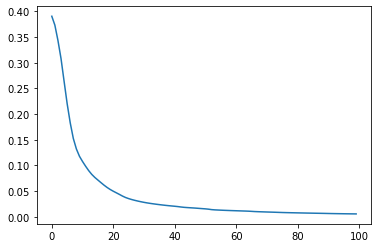

In [19]:
plt.plot(loss_history)